In [6]:
import os, sys
import numpy as np
from numpy.random import multinomial
import process_relion
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
#GPU or CPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

In [8]:
#data path
file_path='F:/script/class2vec/real_star_file/HIV_cryosparc.cs'
datatype=2 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
os.mkdir(output_path)

In [9]:
# parameters
#window size
w = 1

#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44]
#ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46]
ignore_classes=[]

#embedding size
embedding_size=100

#


In [11]:
if datatype<2:
    file_info=process_relion.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=process_relion.process_helical(dataset).extarct_helical()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=process_relion.process_cryosparc_helical(dataset).extract_helical()
corpus_dic=corpus_information[0]
corpus=list(corpus_dic.values())

finish converting
[17, 19, 15, 17, 15, 14, 18, 5, 5, 5, 19, 5, 14, 17, 17, 14, 17, 5, 5, 5, 14, 19, 14, 19, 17, 4, 15, 14, 19, 18, 5, 19, 5, 19, 14, 17, 17, 5, 17, 5, 5, 5, 19, 17, 14, 14, 5, 14, 17, 15, 14, 5, 19, 5, 19, 14, 17, 14, 19, 13, 19, 13, 5, 5, 14, 19, 13, 5, 14, 18, 14, 18, 5, 19, 5, 19, 5, 5, 15, 17, 17, 19, 5, 5, 5, 5, 19, 14, 17, 19, 5, 14, 17, 14, 19, 5, 19, 5, 14, 14, 14, 17, 19, 5, 5, 5, 14, 19, 17, 14, 19, 17, 15, 18, 14, 19, 5, 19, 5, 5, 14, 17, 14, 17, 17, 5, 5, 5, 14, 17, 19, 17, 17, 19, 14, 5, 17, 5, 14, 19, 5, 19, 14, 17, 14, 5, 5, 5, 5, 14, 5, 17, 19, 13, 17, 19, 14, 17, 18, 5, 19, 5, 19, 5, 17, 15, 18, 5, 5, 5]
[2, 14, 8, 14, 3, 15, 15, 15, 15, 19, 15, 15, 19, 19, 15, 19, 9, 19, 2, 8, 14, 8, 14, 13, 14, 14, 8, 14, 19, 15, 3, 15, 15, 19, 15, 19, 19, 6, 19, 8, 14, 13, 2, 13, 8, 14, 19, 14, 3, 15, 15, 19, 15, 19, 9, 19, 19, 18, 19, 6, 19, 8, 15, 8, 14, 8, 14, 15, 15, 19, 15, 19, 9, 15, 16, 19, 19, 19, 19, 8, 2, 8, 14, 8, 14, 3, 15, 14, 19, 14, 3, 15, 3, 15, 15, 1

In [ ]:
#k-mer seperation

In [12]:
## import sentence from txt
#helical_path='./real_star_file/helical.txt'
#corpus=[]
#for line in open(helical_path).readlines():
#    if len(line.strip()) == 0:
#        continue    
#    else:
#        corpus.append(line.split())

In [13]:
vocabulary = set(itertools.chain.from_iterable(corpus))
vocabulary_size = len(vocabulary)

In [14]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [15]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [16]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [17]:
# convert to windoes vector
corpus=corpus
context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus:
    for i, word in enumerate(text):
        if int(word) in ignore_classes:
            continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if int(text[j]) in ignore_classes:
                continue
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 5492 pairs of target and context words


In [18]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [19]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [20]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [21]:
loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

while True:
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=2000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)))
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break

Loss:  tensor(21876.7012, device='cuda:0')
Loss:  tensor(21343.8887, device='cuda:0')
Loss gain: 2.4355249404907227%
Loss:  tensor(20828.3145, device='cuda:0')
Loss gain: 4.792252063751221%
Loss:  tensor(20318.8203, device='cuda:0')
Loss gain: 7.121187210083008%
Loss:  tensor(19818.9453, device='cuda:0')
Loss gain: 9.406152725219727%
Loss:  tensor(19326.9141, device='cuda:0')
Loss gain: 9.449892044067383%
Loss:  tensor(18844.9297, device='cuda:0')
Loss gain: 9.522541046142578%
Loss:  tensor(18370.0605, device='cuda:0')
Loss gain: 9.590909957885742%
Loss:  tensor(17903.8047, device='cuda:0')
Loss gain: 9.66318130493164%
Loss:  tensor(17447.2773, device='cuda:0')
Loss gain: 9.72548770904541%
Loss:  tensor(17002.0527, device='cuda:0')
Loss gain: 9.779165267944336%
Loss:  tensor(16565.5039, device='cuda:0')
Loss gain: 9.823357582092285%
Loss:  tensor(16138.7051, device='cuda:0')
Loss gain: 9.858796119689941%
Loss:  tensor(15727.0498, device='cuda:0')
Loss gain: 9.859576225280762%
Loss:  te

Loss:  tensor(1912.4871, device='cuda:0')
Loss gain: 3.5828120708465576%
Loss:  tensor(1896.1360, device='cuda:0')
Loss gain: 3.5004894733428955%
Loss:  tensor(1879.8977, device='cuda:0')
Loss gain: 3.452517032623291%
Loss:  tensor(1864.5049, device='cuda:0')
Loss gain: 3.3852126598358154%
Loss:  tensor(1848.8843, device='cuda:0')
Loss gain: 3.3256583213806152%
Loss:  tensor(1834.7109, device='cuda:0')
Loss gain: 3.239485263824463%
Loss:  tensor(1820.3926, device='cuda:0')
Loss gain: 3.1653385162353516%
Loss:  tensor(1806.1234, device='cuda:0')
Loss gain: 3.131204843521118%
Loss:  tensor(1792.7870, device='cuda:0')
Loss gain: 3.034115791320801%
Loss:  tensor(1779.4989, device='cuda:0')
Loss gain: 3.0093045234680176%
Loss:  tensor(1766.7959, device='cuda:0')
Loss gain: 2.944237470626831%
Loss:  tensor(1754.2927, device='cuda:0')
Loss gain: 2.869720220565796%
Loss:  tensor(1743.0256, device='cuda:0')
Loss gain: 2.7756423950195312%
Loss:  tensor(1731.1758, device='cuda:0')
Loss gain: 2.71

EMBEDDINGS.shape:  torch.Size([14, 100])
1
2
3
4
5
6
7
8


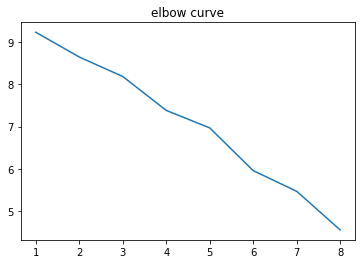

In [22]:
EMBEDDINGS = net.target.weight.data.cpu()
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

iris = load_iris()
x = iris.data

res = []
n_cluster = range(1,9)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

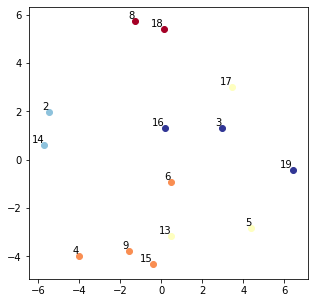

In [23]:
# see the 2D class segments embedding
cluster_number=6
kmeans_best = KMeans(n_clusters=cluster_number).fit_predict(EMBEDDINGS)
pca = PCA(n_components=2).fit_transform(EMBEDDINGS)
EMBEDDINGS = net.target.weight.data.cpu()

plt.figure(figsize = (5, 5))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(pca[i][0], pca[i][1],color=plt.cm.RdYlBu(kmeans_best[i]/4))
    plt.annotate(index_to_word[i], xy = (pca[i][0], pca[i][1]), \
        ha='right',va='bottom')
plt.savefig("w2v.png")
plt.show()

In [24]:
word_to_cluster={}
for i in range(cluster_number):
    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#for i in range(1,vocabulary_size+1):
#    word_to_cluster.append((i,kmeans_best[word_to_index[str(i)]]))
print(word_to_cluster)

{'0': array([ 6, 13], dtype=int64), '1': array([ 3,  5,  7, 10], dtype=int64), '2': array([ 4,  8, 12], dtype=int64), '3': array([1, 9], dtype=int64), '4': array([ 2, 11], dtype=int64), '5': array([14], dtype=int64)}


In [25]:
#using the histogram method to cluster 

#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

In [26]:
filament_cluster_number=2
filament_score=[]
for filament in corpus:
    score=torch.zeros(embedding_size)
    counts=0
    for i in filament:
        if int(i) in ignore_classes:
            continue
        counts+=1
        score=score+EMBEDDINGS[word_to_index[i]]
    if counts==0:
        continue
    score=score/counts
    print(counts)
    filament_score.append(np.array(score))

170
160
149
146
169
155
139
133
164
164
150
159
132
131
156
128
150
122
127
131
144
145
134
147
150
145
126
315
143
172
135
133
130
130
169
143
133


In [27]:
#print(filament_score)
from sklearn.mixture import GaussianMixture
pca_sum = PCA(n_components=2).fit_transform(filament_score)
cluster_pca = KMeans(n_clusters=filament_cluster_number).fit_predict(pca_sum)

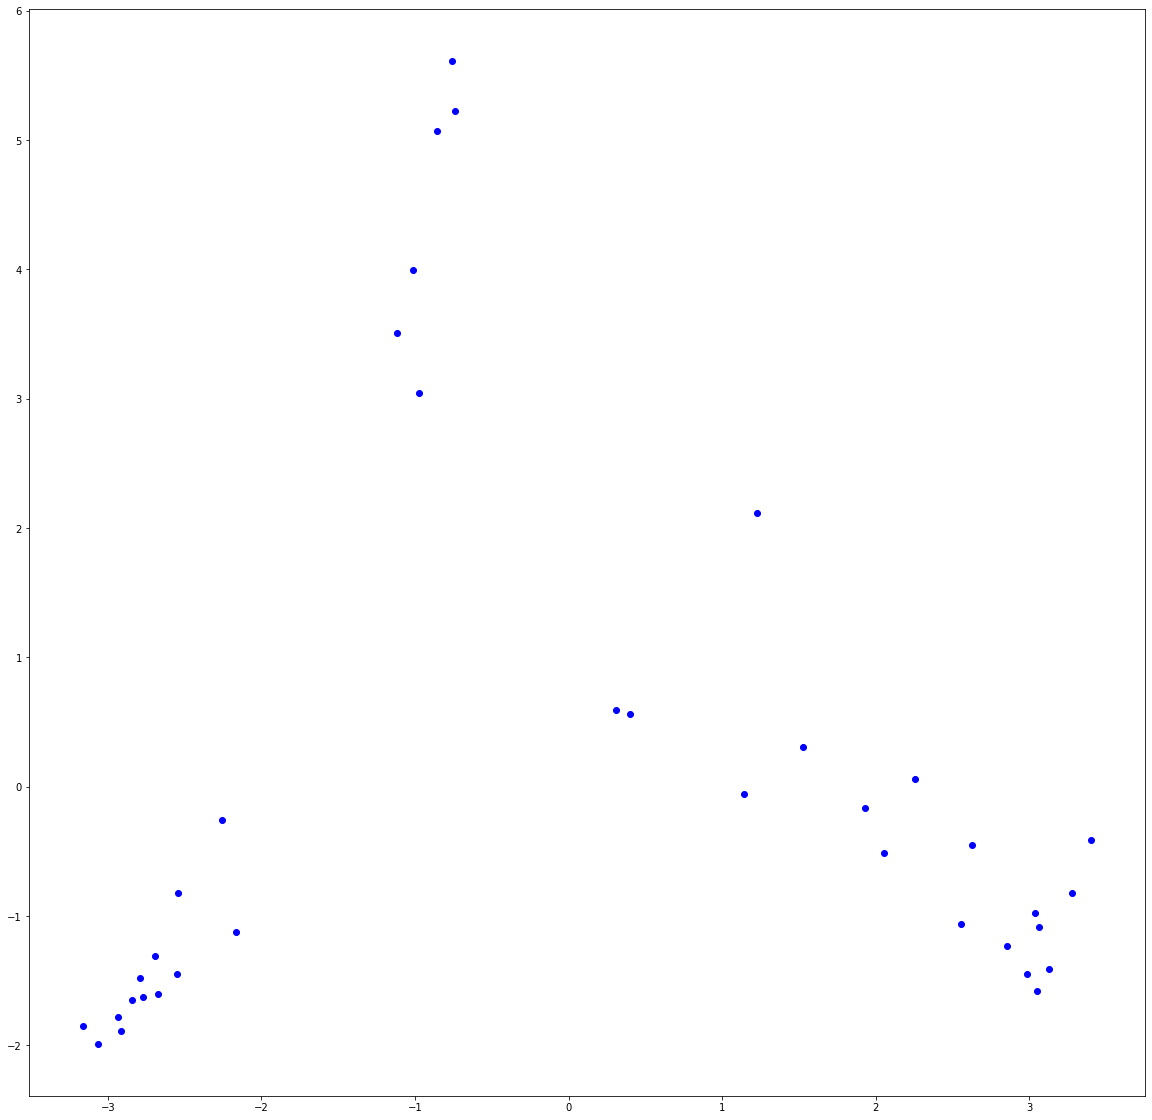

In [28]:
plt.figure(figsize = (20, 20))
for i in range(len(corpus)):
    plt.scatter(pca_sum[i][0], pca_sum[i][1],color='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

In [36]:
import umap
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
reducer = umap.UMAP()
umap = reducer.fit_transform(filament_score)
cluster_umap = SpectralClustering(n_clusters=2).fit_predict(umap)

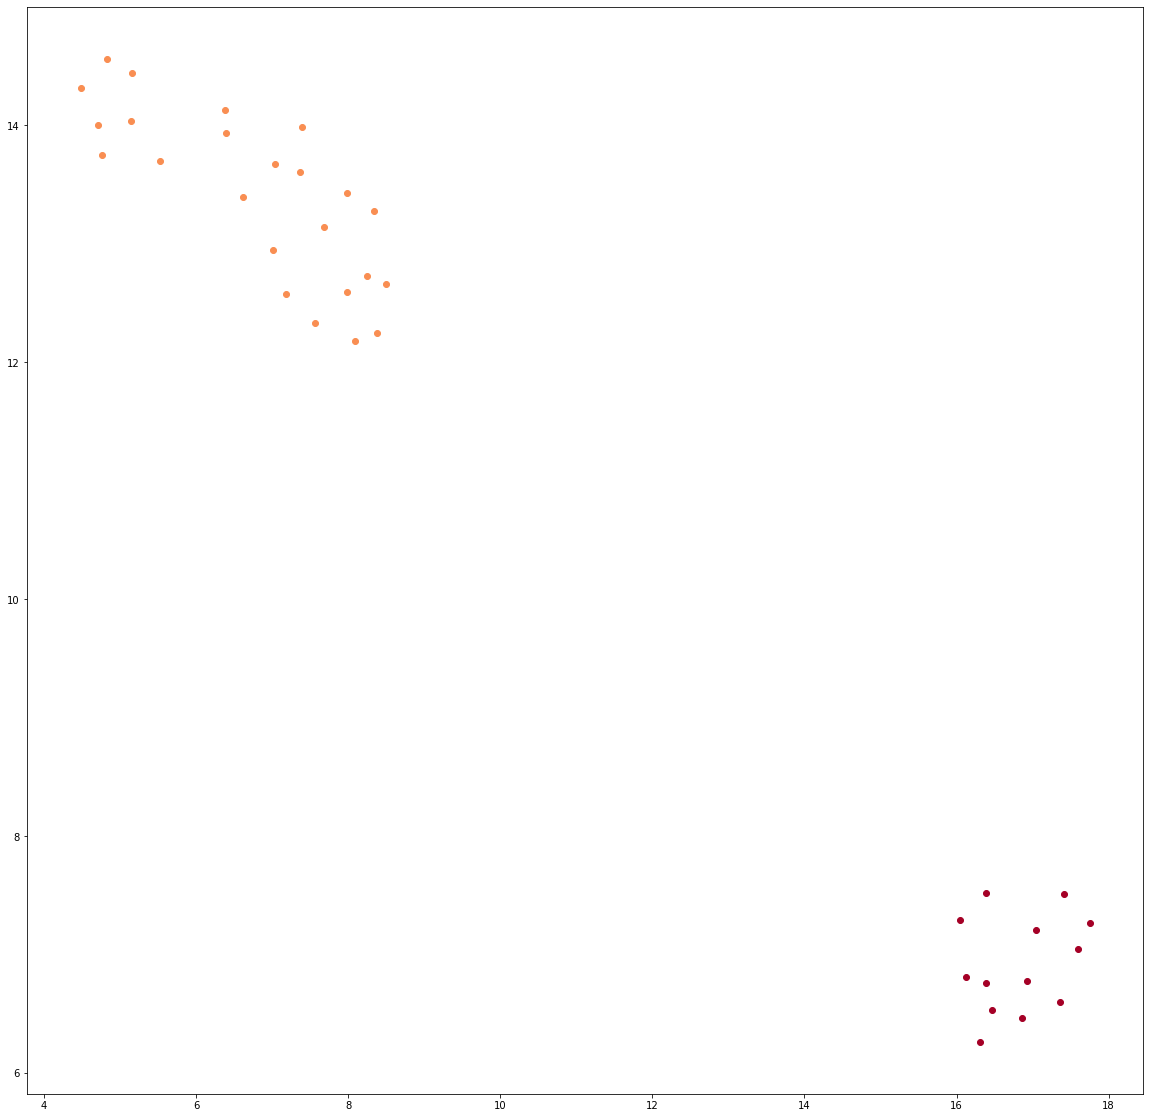

In [37]:
plt.figure(figsize = (20, 20))
for i in range(len(corpus)):
    plt.scatter(umap[i][0], umap[i][1],color=plt.cm.RdYlBu(cluster_umap[i]/4))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_ignore_umap.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(kmeans_umap[i]/4)

In [ ]:
#from sklearn.manifold import MDS
#MDS = MDS(n_components=2).fit_transform(filament_score)

In [ ]:
#plt.figure(figsize = (20, 20))
#for i in range(len(cluster_corpus)):
#    plt.scatter(MDS[i][0], MDS[i][1],color='blue')
#plt.savefig(os.path.splitext(file_path)[0]+"_MDS.png")
#plt.show()

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=cluster_umap
for i in range(len(cluster_choice)):
    lst=corpus[i]
    cluster_number=cluster_choice[i]
    cluster_name='cluster'+str(cluster_number)
    cluster_nameID='clusterID'+str(cluster_number)
    for j in range(len(lst)):
        locals()[cluster_name].append(data[data_line])
        locals()[cluster_nameID].append(data[data_line][6][19:21])
        data_line+=1

In [ ]:
# check rate of successful
labels=['38','29']
distribution_hist_all=[]
for i in range(filament_cluster_number):
    distribution_hist=[]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        group_percentage=lst.count(labels[j])/len(lst)
        distribution_hist.append(group_percentage)
    distribution_hist_all.append(distribution_hist)
print(distribution_hist_all)

In [ ]:
print(len(data),len(cluster0),len(cluster1))

In [ ]:
fig, ax = plt.subplots(1,filament_cluster_number)
labels_name=['PHF','SF']
for i in range(filament_cluster_number):
    ax[i].bar(range(filament_cluster_number),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
#plt.savefig('./confusion_matrix/'+"10230_tau_distr_Loss_per10-2.png")

In [ ]:
# write relion

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if relion_31 is True:
        output=process_relion.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    else:
        output=process_relion.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
with open('cluster_umap.npy', 'wb') as f:
    np.save(f, umap)